# 2023 Fall AI605 Assignment 2: Attention and Transformers

## Rubric

### Deadline

The deadline for this assignment is: Friday 20th October 2023 (Week 8) 11:59pm

### Submission

Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit the Jupyter Notebook file (.ipynb) with all code and model outputs. **For Problem 3.4, you must submit the training curve (loss against traning step) with your notebook**

Use in-line LaTeX for mathematical expressions.

### Collaboration

This assignment is an individual assingnment. It is **not** a group assignment so make sure your answer and code are your own.

### Grading

The total number of marks avaiable is 25 points.

### Environment

The use of a GPU is recommended for problem 3. For Problem 3.4, limit computation time to approximately 2 hours with a GPU. The suggested environment for this is Python 3.9. Run the following cell to set up the environment.

### Data

Problem 3.4 will make use of the English portion of the C4 dataset. We have prepared a sample of 10,000,000 sentences for training.

### Libraries

The following libraries should be used for the project. You should not need any other libraries.


In [1]:
#!pip install torch tqdm datasets transformers

# Problem 1 - Attention (10 points)


Recall that attention can be viewed as a weighted sum of vectors:

$$\mathbf{z} = \sum_{c=1}^n \alpha_i \mathbf{h}_i$$

Where, in dot product attention, the weights $\alpha = \{\alpha_1,\ldots,\alpha_n \}$ are determined as softmax over the inner product of the vector $\mathbf{h}_i \in \{\mathbf{h}_1,\ldots, \mathbf{h}_n\}$ and some query $\mathbf{q}$ where $\mathbf{q} \in \mathbb{R}^d$ and $\mathbf{h}_i\in\mathbb{R}^d$.

$$\alpha_i = \frac{\exp \mathbf{h}_i^T \mathbf{q}}{\sum_{j=1}^n \exp \mathbf{h}_j^T \mathbf{q}}$$


**Problem 1.1** (2 point) State the bounds of each element in $\alpha$ (1 point). Is it a well-formed categorical probability distribution? **Explain why** (1 point)


Given the definition of softmax, let us first state the bounds of each element in $\alpha$.

For each $\alpha_i$:

1. The numerator is $\exp \mathbf{h}_i^\top \mathbf{q}$, which is always non-negative (since the exponential function always produces a non-negative value).
2. The denominator is the sum of all such non-negative values. Therefore, the denominator is also always positive and at least as large as the numerator.

Thus, for each $i$: $0 \leq \alpha_i \leq 1$.

This shows the bounds of each element in $\alpha$.

Now, to determine if it is a well-formed categorical probability distribution:

1. As mentioned before, each $\alpha_i$ is bounded by $[0, 1]$.
2. The sum of all $\alpha_i$'s is $1$. This is inherent to the softmax operation.

$$
\sum_{i=1}^n \alpha_i = \sum_{i=1}^n \frac{\exp \mathbf{h}_i^\top \mathbf{q}}{\sum_{j=1}^n \exp \mathbf{h}_j^\top \mathbf{q}} = \frac{\sum_{i=1}^n \exp \mathbf{h}_i^\top \mathbf{q}}{\sum_{j=1}^n \exp \mathbf{h}_j^\top \mathbf{q}} = 1
$$

Given these two properties, we can conclude that $\alpha$ is a well-formed categorical probability distribution. The elements of $\alpha$ are non-negative, they sum to 1, and each element represents the probability of the corresponding $\mathbf{h}_i$.


For each $\alpha_i$:

1. The numerator is $\exp \mathbf{h}_i^\top \mathbf{q}$, which is always non-negative (since the exponential function always produces a non-negative value).
2. The denominator is the sum of all such non-negative values. Therefore, the denominator is also always positive and at least as large as the numerator.

Thus, for each $i$: $0 \leq \alpha_i \leq 1$.

This shows the bounds of each element in $\alpha$.

Now, to determine if it's a well-formed categorical probability distribution:

1. As mentioned before, each $\alpha_i$ is bounded by [0, 1].
2. The sum of all $\alpha_i$'s is 1. This is inherent to the softmax operation.

$$
\sum_{i=1}^n \alpha_i = \sum_{i=1}^n \frac{\exp \mathbf{h}_i^\top \mathbf{q}}{\sum_{j=1}^n \exp \mathbf{h}_j^\top \mathbf{q}} = \frac{\sum_{i=1}^n \exp \mathbf{h}_i^\top \mathbf{q}}{\sum_{j=1}^n \exp \mathbf{h}_j^\top \mathbf{q}} = 1
$$

Given these two properties, we can conclude that $\alpha$ is a well-formed categorical probability distribution. The elements of $\alpha$ are non-negative, they sum to 1, and each element represents the probability of the corresponding $\mathbf{h}_i$.


**Problem 1.2** (2 point) Compare the attention mechanisms of Dot Product attention, Bahdanau (concatenate) attention and Luong (linear) attention from the lecture in Week 5. Assuming a hidden dimension size of $d$ dimensions, compare how many additional parameters these attention mechanisms introduce.


- **Dot product attention**

  $$
  \text{score}(\mathbf{u}, \mathbf{v}) = \mathbf{u} \cdot \mathbf{v}
  $$

  Introduces zero learnable parameters.

- **Bahdanau attention**

  $$
  \text{score}(\mathbf{u}, \mathbf{v}) = \mathbf{w}^\top \tanh(W_1\mathbf{u} + W_2\mathbf{v})
  $$

  Introduces three parameter sets $\mathbf{w}$, $W_1$, and $W_2$.
  Here, $\mathbf{w} \in \mathbb{R}^d$ and $W_i \in \mathbb{R}^{d \times d}$.

  In total, $d + 2d^2$ parameters were introduced.

- **Luong attention**

  $$
  \text{score}(\mathbf{u}, \mathbf{v}) = \mathbf{v}^\top W \mathbf{u}
  $$

  Introduces one parameter set $W$, where $W \in \mathbb{R}^{d \times d}$.

  In total, $d^2$ parameters were introduced.


**Problem 1.3** (3 point) Using Bahdanau attention for the task of machine translation as an example, demonstrate how this attention mechanism captures long range dependencies. Support your answer with an example showing computation of attention.


Bahdanau attention allows the model to focus on different parts of the input sequence when producing each word of the output sequence.

Let us consider a machine translation task. Let $\mathbf{x}_i$ and $\mathbf{y}_i$ be the $i$-th token of the source (input) and target (output) sequence. Also, denote by $\mathbf{h}_i$ the hidden state of the encoder at time step $i$. Then, the context for decoding time step $i$ is given as a weighted sum of source tokens:

$$
\mathbf{c}_i = \sum_{j=1}^{|X|} \alpha_{i, j} \mathbf{h}_j
$$

Here, $\alpha_{i, j}$ is defined as:

$$
\begin{align*}
\alpha_{i, j} &= \frac{\exp(\text{score}(\mathbf{y}_{i-1}, \mathbf{h}_j))}{\sum_{k=1}^{|X|}\exp(\text{score}(\mathbf{y}_{i-1}, \mathbf{h}_k))}\\
&= \frac{\exp(\mathbf{w}^\top \tanh(W_1^\top \mathbf{y}_{i-1} + W_2^\top \mathbf{h}_j))}{\sum_{k=1}^{|X|}\exp(\mathbf{w}^\top \tanh(W_1^\top \mathbf{y}_{i-1} + W_2^\top \mathbf{h}_k))}
\end{align*}
$$

where $|X|$ is the number of tokens in the input sequence.

Here, note that $\mathbf{w} \in \mathbb{R}^d$ and $W_1, W_2 \in \mathbb{R}^{d \times d}$ are all learnable parameters, as discussed in the previous problem.

This captures long range dependencies by allowing the decoder to attend to all positions in the input sequence, regardless of their distance. When computing the attention weights, the model takes into consideration all encoder hidden states $\mathbf{h}_j$​ corresponding to each token in the source sequence, thus giving it the ability to learn which parts of the input are most relevant for producing the current output token.


**Problem 1.4** (1 point) In the context of dot-product attnetion, provide examples of scenarios where a particular attention weight $\alpha_i$ dominates other attention weights in the distribution (i.e. $\alpha_i \gg \alpha_j, \forall j \in \{1, \ldots, n\}, i \neq j$), and discuss the contexts or types of data where this could occur.


In the context of dot-product attention, the attention weight $\alpha_i$ is determined by the dot product of the query $\mathbf{q}$ and key $\mathbf{h}_i$​. A larger dot product indicates a higher degree of similarity or alignment between the query and the key, leading to a larger attention weight after the softmax operation.

In some cases, a particular attention weight might dominate other attention weights. One such possible scenario is that the source sequence containing redundant information. If the source sequence contains repeated or redundant information and the query strongly matches one of those repetitions, then that specific $\alpha_i$​ will dominate.

Otherwise, if the query vector and one of the key vectors are almost parallel (or very similar in terms of direction and magnitude), their dot product will be high, causing that specific attention weight to dominate.


**Problem 1.5** (2 points) Consider the role of multi-head attention in transformer models. How can it alleviate the problem of a single $\alpha_i$ dominating the attention distribution? Provide examples to support your explanation


According to the paper 'Attention is All You Need', multi-head attention 'allows the model to jointly attend to information from different representation subspaces at different positions.' It is designed to capture different types of dependencies in the data by having multiple sets of attention weights and combining their outputs. This means that even if one attention head produces a dominating $\alpha_i$​, other heads might distribute attention differently, capturing other aspects of the input data.

The multi-head attention is given as follows:

$$
\text{MultiHead}(Q, K, V) = \text{concat}(\text{head}_1, \cdots, \text{head}_h)W^O
$$

where

$$
\begin{align*}
\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i),\\
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} \right)V
\end{align*}
$$

Here, different attention heads can potentially learn to focus on different parts of the input, thereby capturing diverse relationships in the data. For instance, one might focus on local dependencies, another on longer-range dependencies, and another on specific syntactic or semantic patterns.

The followings are some examples.

- **Anaphora Resolution**: In the sentence "Jane dropped her pencil because she was in a hurry.", the reference of "she" can be ambiguous without context. One attention head might focus predominantly on the word "Jane" to resolve the gender and identify the antecedent, while another head might attend more to the context "in a hurry" to capture the reason or action associated with "Jane". Together, they ensure that both the antecedent and the context are captured.

- **Long-Range Dependencies**: In the sentence "Despite the rain, the event, which many believed would be cancelled, went on as scheduled.", capturing the relationship between "rain" and "event" can be crucial. While one head might attend strongly to "rain" when processing "event" to understand the potential challenge, another head might focus on "went on as scheduled" to capture the outcome. This ensures the model recognises both the potential issue (rain) and the resulting action (event not cancelled).

- **Homonyms**: In the sentence "The bank by the river had a lot of grass.", understanding the correct meaning of "bank" is vital. One head might focus on "river" to capture the context that "bank" refers to the side of a river and not a financial institution, while another head might attend to "grass" to further support that interpretation.


# Problem 2 - Transformer Architecture (5 points)


**Problem 2.1** (2 points) In your own words, describe the key features of the transformer neural network architecture. Use equations where appropriate (max 200 words)


- **Self-Attention Mechanism**: At its core, transformers utilise self-attention, allowing each token in the input sequence to focus on other tokens, capturing dependencies irrespective of distance.

- **Multi-Head Attention**: Rather than a single set of attention mechanisms, transformers deploy multiple heads working in parallel, each capturing different types of relationships or features in the data.

- **Positional Encoding**: Since transformers lack inherent sequence awareness (unlike RNNs or LSTMs), they utilise positional encodings. These are added to the embeddings to provide information about the position of each token in the sequence.

- **Feed-forward Neural Networks**: Each transformer block contains feed-forward neural networks operating on individual tokens independently, enabling parallel processing.

- **Layer Normalisation & Residual Connections**: Each sub-layer (like self-attention or feed-forward neural networks) in a transformer has a residual connection around it, followed by layer normalisation. This helps in training deep transformer models by mitigating the vanishing gradient problem.


**Problem 2.2** (2 points) One of the features of the transformer architecture is the residual connections. The transformer architecture uses residual connections (https://arxiv.org/pdf/1512.03385.pdf) over both the feedforward and multi-head attention sub-layers.

- (1) Describe how these residual connections function and the advantages of using them.
- (2) Compare the derivative of the loss ($\frac{\partial L}{\partial \mathbf{x}}$) of a 2-layer feed-forward layer and a feed-forward layer with relu activation ($\mathbf{z}= \mathbf{W}_2^T \text{ReLU}(\mathbf{W}_1^T \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2}$) both with and without the residual connection


(1)

Residual connections involve skipping one or more layers and directly adding the input to the output. There are some advantages to using the residual connections in the architecture. First, residual connections facilitate the backpropagation of gradients through the network, preventing the training signal from being unused in backpropagation step due to gradient vanishing. Thus, with residual connections, the network can be made deeper without the fear of making it harder to train, leading to better feature extraction and improved performance. Moreover, if some layers do not need to change the input representation, it is easier for them to learn the identity function with the help of residual connections.

(2)

We are given a 2-layer feed-forward layer with ReLU activation:

$$
\mathbf{z}= W_2^\top \text{ReLU}(W_1^\top \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2}
$$

Without residual connection, if we want to compute $\frac{\partial L}{\partial \mathbf{x}}$, we would backpropagate through both the ReLU and the linear transformations:

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial \mathbf{x}} &= \frac{\partial \mathcal{L}}{\partial \mathbf{z}}\frac{\partial \mathbf{z}}{\partial \mathbf{x}}\\
&= \frac{\partial \mathcal{L}}{\partial \mathbf{z}} \left( \frac{\partial}{\partial \mathbf{x}} \left( W_2^\top \text{ReLU}(W_1^\top \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2} \right)\right)\\
&= \frac{\partial \mathcal{L}}{\partial \mathbf{z}} W_2^\top W_1^\top
\end{align*}
$$

Since $\frac{\partial}{\partial x} \text{ReLU}(x)$ is either $1$ or $0$, for comparison let us assume that it has a derivative of $1$ for all indices of $W_1^\top \mathbf{x} + \mathbf{b_1}$. i.e., $\frac{\partial}{\partial \mathbf{o}} \text{ReLU}(\mathbf{o}) = I$, where $\mathbf{o} = W_1^\top \mathbf{x} + \mathbf{b_1}$.

With a residual connection, the output becomes:

$$
\mathbf{z} = \mathbf{x} + W_2^\top \text{ReLU}(W_1^\top \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2}
$$

In this case, when computing $\frac{\partial \mathcal{L}}{\partial \mathbf{x}}$, there are two parts: the gradient flowing through the skipped connection and the gradient flowing through the layers:

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial \mathbf{x}} &= \frac{\partial \mathcal{L}}{\partial \mathbf{z}}\frac{\partial \mathbf{z}}{\partial \mathbf{x}}\\
&= \frac{\partial \mathcal{L}}{\partial \mathbf{z}} \left( \frac{\partial}{\partial \mathbf{x}} \left( \mathbf{x} + W_2^\top \text{ReLU}(W_1^\top \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2} \right)\right)\\
&= \frac{\partial \mathcal{L}}{\partial \mathbf{z}} \left( I + W_2^\top W_1^\top \right)
\end{align*}
$$

Again we assume that $\frac{\partial}{\partial \mathbf{o}} \text{ReLU}(\mathbf{o}) = I$. The dimensions of $I$ and $W_2^\top W_1^\top$ always match because by definition $\mathbf{x}$ and $W_2^\top \text{ReLU}(\mathbf{o})$ can be added together, thus having the same dimensions.

The addition of $I$ is due to the residual connection. This ensures that a portion of the gradient always flows directly backward, which is the key reason residual connections help mitigate the vanishing gradient problem.


**Problem 2.3** (1 point) What feature in the transformer architecture limits the ability of the transformer model to encode sequential information? Describe how positional encoding compensates for the model's lack of inherent sequence awareness


Unlike RNNs and LSTMs, the transformer architecture doesn't inherently process sequences in a sequential manner. Instead, it processes all tokens in the input simultaneously. This parallel processing is one of the key reasons transformers are computationally efficient. However, this also means that in their base design, transformers lack inherent sequence awareness or the ability to naturally understand the order of tokens in a sequence.

Positional encoding compensates for this limitation. Positional encoding provides a representation of position and injects this information into the model. By adding positional encodings to the embeddings of tokens before they are fed into the transformer, each token is provided with information about its position in the sequence.

The most common positional encoding method is computed as following:

$$
\begin{align*}
\text{PE}_{(\text{pos}, 2i)} &= \sin\left( \frac{\text{pos}}{10000^{2i/d_m}} \right)\\
\text{PE}_{(\text{pos}, 2i+1)} &= \cos\left( \frac{\text{pos}}{10000^{2i/d_m}} \right)
\end{align*}
$$

where $\text{pos}$ is the position and $i$ is the dimension.

The choice of this function is such that it provides a unique encoding for each position and is easily learnable. As the model trains, it can use these encodings to attend to tokens based on their position in the sequence, effectively giving the transformer a sense of order and allowing it to recognise patterns that depend on the position of tokens.


# Problem 3 - Transformer Language Model Training Objectives (10 points)


This problem explores the T5 language model: https://arxiv.org/pdf/1910.10683.pdf
The HuggingFace transformers implementation of T5 will be used. You will train the model from scratch. The pre-trained model must not be used. However, it is acceptable to use the built-in tokenizer without training it from scratch. Documentation for the HuggingFace implementation can be found here: https://huggingface.co/docs/transformers/model_doc/t5


**Problem 3.1** (2 points) Provide your own implementation of the training data generation function (Figure 2) for the unsupervised objective in T5. The input to your function should be original text from the internet. The two outputs of the function should be the masked text and the targets for the model to predict.

- When implementing the function, randomly remove 15% of the tokens from the input text.
- Demonstrate your function for a sample of 5 sentences.
- The T5 tokenizer has special tokens for the placeholders: https://huggingface.co/t5-small/blob/main/tokenizer_config.json


In [2]:
import os


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import random
from transformers import T5Tokenizer
from typing import List, Tuple

tokenizer = T5Tokenizer.from_pretrained("t5-small")


def mask_tokens(text: str) -> Tuple[List[str], List[str]]:
    if not text:
        return [""], [""]

    tokens = tokenizer.tokenize(text)

    token_len = len(tokens)
    mask_count = int(0.15 * token_len)
    if mask_count < 1:
        return text, [""]

    mask_indices = random.sample(range(token_len), mask_count)
    mask_indices.sort()

    masked_input = []
    targets = []
    extra_id = 0
    skip = False

    for idx in range(token_len):
        if skip:
            skip = False
            continue

        if idx in mask_indices:
            masked_input.append(f"<extra_id_{extra_id}>")
            masked_span = [tokens[idx]]
            while (idx + 1) in mask_indices:
                idx += 1
                masked_span.append(tokens[idx])
                skip = True
            if idx > 0:
                targets.append(f"<extra_id_{extra_id}>")
            targets.extend(masked_span)
            extra_id += 1
        else:
            masked_input.append(tokens[idx])

    if masked_input[-1] != f"<extra_id_{extra_id - 1}>":
        targets.append(f"<extra_id_{extra_id}>")

    return masked_input, targets

In [4]:
# From <The Presentation of Self in Everyday Life> by Erving Goffman :)
sentences = [
    "When an individual enters the presence of others, they commonly seek to acquire information about him or so to bring into play information about him already possessed.",
    "They will be interested in his general socio-economic status, his conception of self, his attitude towards them, his competence, his trustworthiness, etc.",
    "Although some of this information seems to be sought almost as an end in itself, there are usually quite practical reasons for acquiring it.",
    "Information about the individual helps to define the situation, enabling others to know in advance what he will expect of them and what they may expect of him.",
    "Informed in these ways, the others will know how best to act in order to call forth a desired response from him.",
]


for sentence in sentences:
    input_text, labels = mask_tokens(sentence)
    print("-" * 50)
    print("Original:", sentence)
    print("Input   :", tokenizer.decode(tokenizer.encode(input_text)))
    print("Labels  :", tokenizer.decode(tokenizer.encode(labels)))
print("-" * 50)

--------------------------------------------------
Original: When an individual enters the presence of others, they commonly seek to acquire information about him or so to bring into play information about him already possessed.
Input   : When an individual enters the presence <extra_id_0> <extra_id_1> they commonly seek to acquire information about him or so to bring into <extra_id_2> information about him already possessed.</s>
Labels  : <extra_id_0> of others, <extra_id_1>, <extra_id_2> play <extra_id_3> </s>
--------------------------------------------------
Original: They will be interested in his general socio-economic status, his conception of self, his attitude towards them, his competence, his trustworthiness, etc.
Input   : They will <extra_id_0> interested in his general <extra_id_1> -economic status, his conception of self, his <extra_id_2> towards them, his competence <extra_id_3> his trustworthiness, etc.</s>
Labels  : <extra_id_0> be <extra_id_1> socio <extra_id_2> attit

**Problem 3.2** (2 points) After T5 model is pre-trained with the unsupervised objective, (Raffel et al. 2019) fine-tuned for a number of downstream natural language understanding tasks. What is meant by pre-training and fine-tuning? Provide references to other notable examples / models in recent NLP papers other than T5.


- **Pre-training**: In the context of neural networks and particularly in NLP models, pre-training refers to training a model on a large dataset, often with vast amounts of text, to learn underlying patterns, structures, and representations in the language. This process typically involves a general objective, like predicting the next word in a sequence (language modelling), which allows the model to gain a broad understanding of the language. The resulting model can capture a lot of the syntax, semantics, and even some of the world knowledge embedded in the training data.

- **Fine-tuning**: After the pre-training phase, the model, which has now learned general language features, is further trained on a smaller, task-specific dataset. This process is called fine-tuning. During fine-tuning, the model is tailored to perform a specific task, such as classification, translation, question-answering, etc., and adapts its previously learned general knowledge to this specific task.

Notable examples/models in recent NLP research that use pre-training and fine-tuning include:

- **GPT**: GPT is pre-trained as a unidirectional language model, and fine-tuned for specific tasks. It is trained to predict the next token given some context window.\
  _Reference: [Improving Language Understanding by Generative Pre-training](https://www.mikecaptain.com/resources/pdf/GPT-1.pdf)_

- **LLaMA**: LLaMA has a similar architecture to GPT, and is pre-trained on publicly available datasets (such as English CommonCrawl, Github, and Wikipedia) exclusively.\
  _Reference: [LLaMA: Open and Efficient Foundation Language Models](https://arxiv.org/abs/2302.13971)_

- **ChatDoctor**: ChatDoctor is a specialised language model with enhanced accuracy in medical advice, created by fine-tuning the pretrained LLaMA model using a large dataset of 100,000 patient-doctor dialogues sourced from a widely used online medical consultation platform.\
  _Reference: [ChatDoctor: A Medical Chat Model Fine-Tuned on a Large Language Model Meta-AI (LLaMA) Using Medical Domain Knowledge](https://arxiv.org/abs/2303.14070)_


**Problem 3.3** (2 points) Transformer models, such as T5, are often trained with learning rate schedule such as inverse square root: where $s = 1/\sqrt{\max(n,k)}$ where n is the number of warm up steps and k is the current step number.

- Provde a python implementation of this learning rate schedule function
- For n=10000, plot the schedule $s$ against $k$.
- Explain in your own words why this learning rate schedule could benefit training a transformer model.


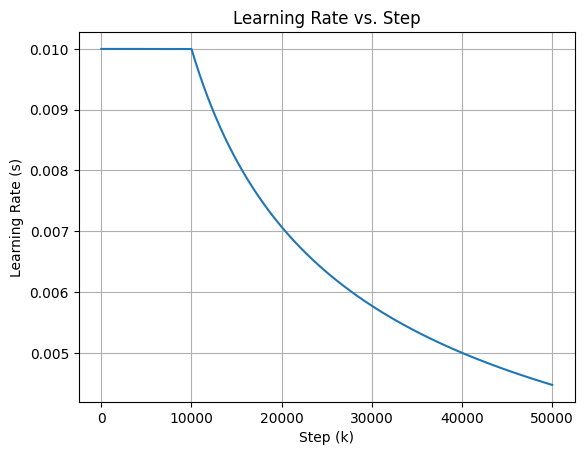

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def inverse_sqrt_lr(k: int, n: int = 10000) -> float:
    if k == 0:
        return 1 / np.sqrt(n)
    return 1 / np.sqrt(max(n, k))


k_values = np.arange(1, 50000)
s_values = [inverse_sqrt_lr(k, n=10000) for k in k_values]

plt.plot(k_values, s_values)
plt.title("Learning Rate vs. Step")
plt.xlabel("Step (k)")
plt.ylabel("Learning Rate (s)")
plt.grid(True)
plt.show()

This schedule benefits the training of transformer models in several ways.

At the beginning of training, when weights are initialised (often randomly), the model's predictions are likely far from optimal. Thus, a higher learning rate allows the model to make larger updates and converge faster.

As training progresses, the model starts to fit the data more closely, and the loss landscape becomes more intricate with narrower regions of interest. Here, using a high learning rate might make the model overshoot these narrow regions. Hence, reducing the learning rate as training goes on allows the model to make finer adjustments and potentially settle into deeper, narrower parts of the loss function (i.e., local minima).

If the learning rate was constant, with high learning rates, the model might bounce around and miss the local minima, while extremely low learning rates might make the model converge too slowly or get stuck in less optimal minima. The inverse square root schedule tries to get the best of both worlds by starting fast and then slowing down, allowing the model to navigate the complex loss landscape of Transformer models effectively.


**Problem 3.4** (4 points) Using the huggingface library, initialize a new instance of a T5-small model (i.e. randomly initialized, do not use the pre-trained model) and train it on WikiText103 dataset with the T5 unsupervised pretraining objective.

- Report your training and validation loss. Submit a graph of these along with your submission of the jupyter notebook.
- Budget a maximum of 2 hours of training time
- It is recommended to use the learning rate and scheduling hyperparemeters reported in the paper. However, smaller batch sizes and smaller max sequence lenghts are recommended for for slower hardware.
- PyTorch does not have the correct learning rate scheduler, a suitable alternative would be LamdaLR function and to call the function you wrote in Problem 3.3. https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html
- It is acceptable to use the HuggingFace tokenizer, you do not have to train this from scratch.
- It is acceptable to use the HuggingFace trainer
- Graphing the training/validation loss may be achieved using W&B, TensorBoard or similar, or implemented manually

(Rubric: 1 point pre-processing and packing data, 1 point for appropriate training, 2 points successful convergence on the training/validation loss)


In [6]:
import torch
import datasets
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, load_from_disk
from transformers import T5Tokenizer

In [7]:
data = load_dataset("wikitext", "wikitext-103-v1")


class MaskedDataset(Dataset):
    def __init__(self, data: datasets.Dataset):
        self.data = data
        self.tokenizer = T5Tokenizer.from_pretrained("t5-small")
        self.max_token_len = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        text = self.data[idx]["text"]
        masked_input, labels = mask_tokens(text)
        masked_input = self.tokenizer.encode(
            masked_input,
            padding="max_length",
            truncation=True,
            max_length=self.max_token_len,
            return_tensors="pt",
        ).squeeze()
        labels = self.tokenizer.encode(
            labels,
            padding="max_length",
            truncation=True,
            max_length=self.max_token_len,
            return_tensors="pt",
        ).squeeze()
        # labels[labels == self.tokenizer.pad_token_id] = -100  # ignore loss

        return {"input_ids": masked_input, "labels": labels}

In [8]:
train_dataset = MaskedDataset(data["train"])
val_dataset = MaskedDataset(data["validation"])
test_dataset = MaskedDataset(data["test"])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import transformers
import wandb
from transformers import T5Config, T5ForConditionalGeneration
from torch.optim.lr_scheduler import LambdaLR
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

config = T5Config(
    vocab_size=tokenizer.vocab_size + 128,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    decoder_start_token_id=tokenizer.pad_token_id,
)
model = T5ForConditionalGeneration(config)  # Randomly initialised
model = model.to(device)
optimizer = transformers.Adafactor(model.parameters(), lr=1, relative_step=False)
scheduler = LambdaLR(optimizer, lambda k: inverse_sqrt_lr(k, 10000))

In [ ]:
wandb.init(project="ai605-assignment2")

In [11]:
num_epochs = 5
progress_bar = tqdm(range(num_epochs * len(train_loader)))


print(
    "Initial learning rate: {}".format(optimizer.state_dict()["param_groups"][0]["lr"])
)
for epoch in range(num_epochs):
    model.train()
    for train_iter, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()
        wandb.log({"Training Loss": loss.item()})

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update()

        if train_iter % 100 == 0:
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Iteration {train_iter}, Training Loss: {loss.item():.4f}, Learning Rate: {optimizer.state_dict()['param_groups'][0]['lr']}"
            )
        if train_iter % 1000 == 0:
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for _, batch in enumerate(val_loader):
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**batch)
                    val_loss += outputs.loss

                val_loss /= len(val_loader)

                wandb.log({"Validation Loss": val_loss})
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, Iteration {train_iter}, Validation Loss: {val_loss:.4f}"
                )

    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        },
        f"./t5_from_scratch.pth",
    )

  0%|          | 0/1125845 [00:00<?, ?it/s]

Initial learning rate: 0.01


  0%|          | 1/1125845 [00:00<289:28:07,  1.08it/s]

Epoch 1/5, Iteration 0, Training Loss: 6.0109, Learning Rate: 0.01
Epoch 1/5, Iteration 0, Validation Loss: 2.4071


  0%|          | 101/1125845 [03:22<244:13:29,  1.28it/s]

Epoch 1/5, Iteration 100, Training Loss: 0.1421, Learning Rate: 0.01


  0%|          | 201/1125845 [04:42<238:29:48,  1.31it/s]

Epoch 1/5, Iteration 200, Training Loss: 0.4408, Learning Rate: 0.01


  0%|          | 301/1125845 [06:01<249:45:32,  1.25it/s]

Epoch 1/5, Iteration 300, Training Loss: 0.8624, Learning Rate: 0.01


  0%|          | 401/1125845 [07:21<254:10:45,  1.23it/s]

Epoch 1/5, Iteration 400, Training Loss: 0.9106, Learning Rate: 0.01


  0%|          | 501/1125845 [08:39<247:06:05,  1.27it/s]

Epoch 1/5, Iteration 500, Training Loss: 0.8955, Learning Rate: 0.01


  0%|          | 601/1125845 [09:58<247:35:50,  1.26it/s]

Epoch 1/5, Iteration 600, Training Loss: 0.5135, Learning Rate: 0.01


  0%|          | 701/1125845 [11:17<254:30:40,  1.23it/s]

Epoch 1/5, Iteration 700, Training Loss: 0.3136, Learning Rate: 0.01


  0%|          | 801/1125845 [12:36<239:29:07,  1.30it/s]

Epoch 1/5, Iteration 800, Training Loss: 1.1899, Learning Rate: 0.01


  0%|          | 901/1125845 [13:55<246:34:20,  1.27it/s]

Epoch 1/5, Iteration 900, Training Loss: 0.9626, Learning Rate: 0.01


  0%|          | 1001/1125845 [15:13<243:39:55,  1.28it/s]

Epoch 1/5, Iteration 1000, Training Loss: 0.3763, Learning Rate: 0.01
Epoch 1/5, Iteration 1000, Validation Loss: 0.6829


  0%|          | 1101/1125845 [18:35<255:28:35,  1.22it/s]  

Epoch 1/5, Iteration 1100, Training Loss: 0.3519, Learning Rate: 0.01


  0%|          | 1201/1125845 [19:53<246:22:34,  1.27it/s]

Epoch 1/5, Iteration 1200, Training Loss: 0.6748, Learning Rate: 0.01


  0%|          | 1301/1125845 [21:14<255:05:40,  1.22it/s]

Epoch 1/5, Iteration 1300, Training Loss: 0.8342, Learning Rate: 0.01


  0%|          | 1401/1125845 [22:35<255:25:11,  1.22it/s]

Epoch 1/5, Iteration 1400, Training Loss: 0.9427, Learning Rate: 0.01


  0%|          | 1501/1125845 [23:55<255:34:48,  1.22it/s]

Epoch 1/5, Iteration 1500, Training Loss: 0.9872, Learning Rate: 0.01


  0%|          | 1601/1125845 [25:15<253:02:02,  1.23it/s]

Epoch 1/5, Iteration 1600, Training Loss: 0.5856, Learning Rate: 0.01


  0%|          | 1701/1125845 [26:35<251:34:40,  1.24it/s]

Epoch 1/5, Iteration 1700, Training Loss: 0.5601, Learning Rate: 0.01


  0%|          | 1801/1125845 [27:56<257:59:00,  1.21it/s]

Epoch 1/5, Iteration 1800, Training Loss: 0.5107, Learning Rate: 0.01


  0%|          | 1901/1125845 [29:16<252:09:33,  1.24it/s]

Epoch 1/5, Iteration 1900, Training Loss: 1.1019, Learning Rate: 0.01


  0%|          | 2001/1125845 [30:38<256:11:19,  1.22it/s]

Epoch 1/5, Iteration 2000, Training Loss: 0.9080, Learning Rate: 0.01
Epoch 1/5, Iteration 2000, Validation Loss: 0.6601


  0%|          | 2101/1125845 [34:02<263:15:46,  1.19it/s]  

Epoch 1/5, Iteration 2100, Training Loss: 0.8763, Learning Rate: 0.01


  0%|          | 2201/1125845 [35:24<257:43:53,  1.21it/s]

Epoch 1/5, Iteration 2200, Training Loss: 0.1151, Learning Rate: 0.01


  0%|          | 2301/1125845 [36:45<244:23:20,  1.28it/s]

Epoch 1/5, Iteration 2300, Training Loss: 0.4655, Learning Rate: 0.01


  0%|          | 2401/1125845 [38:05<243:42:21,  1.28it/s]

Epoch 1/5, Iteration 2400, Training Loss: 0.9863, Learning Rate: 0.01


  0%|          | 2501/1125845 [39:26<252:10:14,  1.24it/s]

Epoch 1/5, Iteration 2500, Training Loss: 0.5787, Learning Rate: 0.01


  0%|          | 2601/1125845 [40:46<257:15:19,  1.21it/s]

Epoch 1/5, Iteration 2600, Training Loss: 0.7824, Learning Rate: 0.01


  0%|          | 2701/1125845 [42:07<250:57:18,  1.24it/s]

Epoch 1/5, Iteration 2700, Training Loss: 0.4050, Learning Rate: 0.01


  0%|          | 2801/1125845 [43:30<256:40:28,  1.22it/s]

Epoch 1/5, Iteration 2800, Training Loss: 0.6250, Learning Rate: 0.01


  0%|          | 2901/1125845 [44:53<268:10:46,  1.16it/s]

Epoch 1/5, Iteration 2900, Training Loss: 0.6668, Learning Rate: 0.01


  0%|          | 3001/1125845 [46:18<268:14:39,  1.16it/s]

Epoch 1/5, Iteration 3000, Training Loss: 0.8066, Learning Rate: 0.01
Epoch 1/5, Iteration 3000, Validation Loss: 0.6555


  0%|          | 3101/1125845 [49:48<264:24:37,  1.18it/s]  

Epoch 1/5, Iteration 3100, Training Loss: 0.8791, Learning Rate: 0.01


  0%|          | 3201/1125845 [51:13<276:46:06,  1.13it/s]

Epoch 1/5, Iteration 3200, Training Loss: 0.2673, Learning Rate: 0.01


  0%|          | 3301/1125845 [52:40<285:26:27,  1.09it/s]

Epoch 1/5, Iteration 3300, Training Loss: 1.0754, Learning Rate: 0.01


  0%|          | 3401/1125845 [54:09<279:37:01,  1.12it/s]

Epoch 1/5, Iteration 3400, Training Loss: 0.4489, Learning Rate: 0.01


  0%|          | 3501/1125845 [55:38<283:47:17,  1.10it/s]

Epoch 1/5, Iteration 3500, Training Loss: 1.3801, Learning Rate: 0.01


  0%|          | 3601/1125845 [57:05<259:02:15,  1.20it/s]

Epoch 1/5, Iteration 3600, Training Loss: 0.4127, Learning Rate: 0.01


  0%|          | 3701/1125845 [58:30<275:06:08,  1.13it/s]

Epoch 1/5, Iteration 3700, Training Loss: 0.4326, Learning Rate: 0.01


  0%|          | 3801/1125845 [59:57<257:19:28,  1.21it/s]

Epoch 1/5, Iteration 3800, Training Loss: 0.8498, Learning Rate: 0.01


  0%|          | 3901/1125845 [1:01:25<279:32:12,  1.11it/s]

Epoch 1/5, Iteration 3900, Training Loss: 0.3520, Learning Rate: 0.01


  0%|          | 4001/1125845 [1:02:56<275:14:58,  1.13it/s]

Epoch 1/5, Iteration 4000, Training Loss: 0.7633, Learning Rate: 0.01
Epoch 1/5, Iteration 4000, Validation Loss: 0.6496


  0%|          | 4101/1125845 [1:06:30<286:17:59,  1.09it/s]  

Epoch 1/5, Iteration 4100, Training Loss: 0.3971, Learning Rate: 0.01


  0%|          | 4201/1125845 [1:08:02<285:27:53,  1.09it/s]

Epoch 1/5, Iteration 4200, Training Loss: 0.2348, Learning Rate: 0.01


  0%|          | 4301/1125845 [1:09:35<280:39:50,  1.11it/s]

Epoch 1/5, Iteration 4300, Training Loss: 0.1904, Learning Rate: 0.01


  0%|          | 4401/1125845 [1:11:08<282:58:12,  1.10it/s]

Epoch 1/5, Iteration 4400, Training Loss: 0.1532, Learning Rate: 0.01


  0%|          | 4501/1125845 [1:12:41<293:53:57,  1.06it/s]

Epoch 1/5, Iteration 4500, Training Loss: 0.8515, Learning Rate: 0.01


  0%|          | 4601/1125845 [1:14:14<288:11:01,  1.08it/s]

Epoch 1/5, Iteration 4600, Training Loss: 0.6148, Learning Rate: 0.01


  0%|          | 4701/1125845 [1:15:44<269:08:49,  1.16it/s]

Epoch 1/5, Iteration 4700, Training Loss: 0.0022, Learning Rate: 0.01


  0%|          | 4801/1125845 [1:17:17<276:53:37,  1.12it/s]

Epoch 1/5, Iteration 4800, Training Loss: 0.5441, Learning Rate: 0.01


  0%|          | 4901/1125845 [1:18:48<279:20:05,  1.11it/s]

Epoch 1/5, Iteration 4900, Training Loss: 0.4396, Learning Rate: 0.01


  0%|          | 5001/1125845 [1:20:22<274:11:23,  1.14it/s]

Epoch 1/5, Iteration 5000, Training Loss: 0.0019, Learning Rate: 0.01
Epoch 1/5, Iteration 5000, Validation Loss: 0.6545


  0%|          | 5101/1125845 [1:23:55<283:39:47,  1.10it/s]  

Epoch 1/5, Iteration 5100, Training Loss: 0.3274, Learning Rate: 0.01


  0%|          | 5201/1125845 [1:25:26<287:12:15,  1.08it/s]

Epoch 1/5, Iteration 5200, Training Loss: 0.2755, Learning Rate: 0.01


  0%|          | 5301/1125845 [1:26:56<273:57:32,  1.14it/s]

Epoch 1/5, Iteration 5300, Training Loss: 0.4958, Learning Rate: 0.01


  0%|          | 5401/1125845 [1:28:24<282:43:53,  1.10it/s]

Epoch 1/5, Iteration 5400, Training Loss: 0.1939, Learning Rate: 0.01


  0%|          | 5501/1125845 [1:29:54<278:17:48,  1.12it/s]

Epoch 1/5, Iteration 5500, Training Loss: 0.9105, Learning Rate: 0.01


  0%|          | 5601/1125845 [1:31:23<294:15:36,  1.06it/s]

Epoch 1/5, Iteration 5600, Training Loss: 1.4044, Learning Rate: 0.01


  1%|          | 5701/1125845 [1:32:53<277:29:11,  1.12it/s]

Epoch 1/5, Iteration 5700, Training Loss: 0.4694, Learning Rate: 0.01


  1%|          | 5801/1125845 [1:34:23<285:51:44,  1.09it/s]

Epoch 1/5, Iteration 5800, Training Loss: 0.4394, Learning Rate: 0.01


  1%|          | 5901/1125845 [1:35:52<285:15:04,  1.09it/s]

Epoch 1/5, Iteration 5900, Training Loss: 0.6268, Learning Rate: 0.01


  1%|          | 6001/1125845 [1:37:24<288:17:16,  1.08it/s]

Epoch 1/5, Iteration 6000, Training Loss: 1.3688, Learning Rate: 0.01
Epoch 1/5, Iteration 6000, Validation Loss: 0.6418


  1%|          | 6101/1125845 [1:40:59<289:27:38,  1.07it/s]  

Epoch 1/5, Iteration 6100, Training Loss: 1.0883, Learning Rate: 0.01


  1%|          | 6201/1125845 [1:42:30<273:02:50,  1.14it/s]

Epoch 1/5, Iteration 6200, Training Loss: 0.4542, Learning Rate: 0.01


  1%|          | 6301/1125845 [1:44:02<282:04:37,  1.10it/s]

Epoch 1/5, Iteration 6300, Training Loss: 0.8508, Learning Rate: 0.01


  1%|          | 6401/1125845 [1:45:35<290:33:00,  1.07it/s]

Epoch 1/5, Iteration 6400, Training Loss: 0.5461, Learning Rate: 0.01


  1%|          | 6501/1125845 [1:47:07<298:44:07,  1.04it/s]

Epoch 1/5, Iteration 6500, Training Loss: 0.7250, Learning Rate: 0.01


  1%|          | 6601/1125845 [1:48:42<286:20:00,  1.09it/s]

Epoch 1/5, Iteration 6600, Training Loss: 0.4029, Learning Rate: 0.01


  1%|          | 6701/1125845 [1:50:15<290:23:59,  1.07it/s]

Epoch 1/5, Iteration 6700, Training Loss: 1.0355, Learning Rate: 0.01


  1%|          | 6801/1125845 [1:51:50<277:54:35,  1.12it/s]

Epoch 1/5, Iteration 6800, Training Loss: 0.3473, Learning Rate: 0.01


  1%|          | 6901/1125845 [1:53:25<294:00:36,  1.06it/s]

Epoch 1/5, Iteration 6900, Training Loss: 0.4436, Learning Rate: 0.01


  1%|          | 7001/1125845 [1:55:00<316:54:42,  1.02s/it]

Epoch 1/5, Iteration 7000, Training Loss: 0.6910, Learning Rate: 0.01
Epoch 1/5, Iteration 7000, Validation Loss: 0.6431


  1%|          | 7101/1125845 [1:58:42<307:51:39,  1.01it/s]  

Epoch 1/5, Iteration 7100, Training Loss: 0.5539, Learning Rate: 0.01


  1%|          | 7201/1125845 [2:00:17<295:42:01,  1.05it/s]

Epoch 1/5, Iteration 7200, Training Loss: 0.7085, Learning Rate: 0.01


  1%|          | 7301/1125845 [2:01:54<289:48:00,  1.07it/s]

Epoch 1/5, Iteration 7300, Training Loss: 0.1984, Learning Rate: 0.01


  1%|          | 7401/1125845 [2:03:32<303:17:55,  1.02it/s]

Epoch 1/5, Iteration 7400, Training Loss: 0.1512, Learning Rate: 0.01


  1%|          | 7501/1125845 [2:05:12<307:19:26,  1.01it/s]

Epoch 1/5, Iteration 7500, Training Loss: 0.3348, Learning Rate: 0.01


  1%|          | 7601/1125845 [2:06:53<324:22:20,  1.04s/it]

Epoch 1/5, Iteration 7600, Training Loss: 0.8087, Learning Rate: 0.01


  1%|          | 7701/1125845 [2:08:33<316:32:42,  1.02s/it]

Epoch 1/5, Iteration 7700, Training Loss: 0.2775, Learning Rate: 0.01


  1%|          | 7801/1125845 [2:10:13<308:46:21,  1.01it/s]

Epoch 1/5, Iteration 7800, Training Loss: 0.7362, Learning Rate: 0.01


  1%|          | 7901/1125845 [2:11:53<310:17:11,  1.00it/s]

Epoch 1/5, Iteration 7900, Training Loss: 0.5587, Learning Rate: 0.01


  1%|          | 8001/1125845 [2:13:32<295:33:18,  1.05it/s]

Epoch 1/5, Iteration 8000, Training Loss: 0.1535, Learning Rate: 0.01
Epoch 1/5, Iteration 8000, Validation Loss: 0.6452


  1%|          | 8101/1125845 [2:17:17<306:04:43,  1.01it/s]  

Epoch 1/5, Iteration 8100, Training Loss: 0.6685, Learning Rate: 0.01


  1%|          | 8201/1125845 [2:18:58<312:01:34,  1.01s/it]

Epoch 1/5, Iteration 8200, Training Loss: 1.2352, Learning Rate: 0.01


  1%|          | 8301/1125845 [2:20:35<285:08:59,  1.09it/s]

Epoch 1/5, Iteration 8300, Training Loss: 0.3700, Learning Rate: 0.01


  1%|          | 8401/1125845 [2:22:12<300:11:17,  1.03it/s]

Epoch 1/5, Iteration 8400, Training Loss: 0.3516, Learning Rate: 0.01


  1%|          | 8501/1125845 [2:23:48<299:44:20,  1.04it/s]

Epoch 1/5, Iteration 8500, Training Loss: 0.8078, Learning Rate: 0.01


  1%|          | 8601/1125845 [2:25:27<306:20:54,  1.01it/s]

Epoch 1/5, Iteration 8600, Training Loss: 0.4425, Learning Rate: 0.01


  1%|          | 8701/1125845 [2:27:07<312:25:30,  1.01s/it]

Epoch 1/5, Iteration 8700, Training Loss: 0.9068, Learning Rate: 0.01


  1%|          | 8801/1125845 [2:28:49<318:20:21,  1.03s/it]

Epoch 1/5, Iteration 8800, Training Loss: 0.8079, Learning Rate: 0.01


  1%|          | 8901/1125845 [2:30:31<306:50:25,  1.01it/s]

Epoch 1/5, Iteration 8900, Training Loss: 0.1326, Learning Rate: 0.01


  1%|          | 9001/1125845 [2:32:14<309:29:57,  1.00it/s]

Epoch 1/5, Iteration 9000, Training Loss: 0.4548, Learning Rate: 0.01
Epoch 1/5, Iteration 9000, Validation Loss: 0.6378


  1%|          | 9101/1125845 [2:36:08<339:15:11,  1.09s/it]  

Epoch 1/5, Iteration 9100, Training Loss: 0.9248, Learning Rate: 0.01


  1%|          | 9201/1125845 [2:37:52<326:25:23,  1.05s/it]

Epoch 1/5, Iteration 9200, Training Loss: 0.8560, Learning Rate: 0.01


  1%|          | 9301/1125845 [2:39:38<332:29:02,  1.07s/it]

Epoch 1/5, Iteration 9300, Training Loss: 0.6999, Learning Rate: 0.01


  1%|          | 9401/1125845 [2:41:25<330:41:12,  1.07s/it]

Epoch 1/5, Iteration 9400, Training Loss: 0.3389, Learning Rate: 0.01


  1%|          | 9501/1125845 [2:43:12<333:53:22,  1.08s/it]

Epoch 1/5, Iteration 9500, Training Loss: 0.4878, Learning Rate: 0.01


  1%|          | 9601/1125845 [2:44:59<329:10:19,  1.06s/it]

Epoch 1/5, Iteration 9600, Training Loss: 0.4207, Learning Rate: 0.01


  1%|          | 9701/1125845 [2:46:46<329:41:07,  1.06s/it]

Epoch 1/5, Iteration 9700, Training Loss: 0.3955, Learning Rate: 0.01


  1%|          | 9801/1125845 [2:48:33<331:14:03,  1.07s/it]

Epoch 1/5, Iteration 9800, Training Loss: 0.7812, Learning Rate: 0.01


  1%|          | 9901/1125845 [2:50:19<328:06:42,  1.06s/it]

Epoch 1/5, Iteration 9900, Training Loss: 0.2062, Learning Rate: 0.01


  1%|          | 10001/1125845 [2:52:05<318:11:57,  1.03s/it]

Epoch 1/5, Iteration 10000, Training Loss: 0.4908, Learning Rate: 0.009999500037496875
Epoch 1/5, Iteration 10000, Validation Loss: 0.6386


  1%|          | 10101/1125845 [2:55:59<332:23:43,  1.07s/it]  

Epoch 1/5, Iteration 10100, Training Loss: 0.3145, Learning Rate: 0.009949879346007117


  1%|          | 10201/1125845 [2:57:47<354:19:28,  1.14s/it]

Epoch 1/5, Iteration 10200, Training Loss: 0.6328, Learning Rate: 0.009900990099009901


  1%|          | 10301/1125845 [2:59:39<367:02:30,  1.18s/it]

Epoch 1/5, Iteration 10300, Training Loss: 1.4924, Learning Rate: 0.009852814501285315


  1%|          | 10401/1125845 [3:01:35<363:11:07,  1.17s/it]

Epoch 1/5, Iteration 10400, Training Loss: 0.5835, Learning Rate: 0.009805335357886892


  1%|          | 10501/1125845 [3:03:25<338:06:05,  1.09s/it]

Epoch 1/5, Iteration 10500, Training Loss: 0.5722, Learning Rate: 0.009758536048356126


  1%|          | 10601/1125845 [3:05:09<311:55:33,  1.01s/it]

Epoch 1/5, Iteration 10600, Training Loss: 0.4313, Learning Rate: 0.00971240050227797


  1%|          | 10701/1125845 [3:06:55<326:47:05,  1.05s/it]

Epoch 1/5, Iteration 10700, Training Loss: 0.2701, Learning Rate: 0.009666913176095693


  1%|          | 10801/1125845 [3:08:44<361:05:39,  1.17s/it]

Epoch 1/5, Iteration 10800, Training Loss: 0.1873, Learning Rate: 0.009622059031109105


  1%|          | 10901/1125845 [3:10:36<329:17:41,  1.06s/it]

Epoch 1/5, Iteration 10900, Training Loss: 0.8968, Learning Rate: 0.009577823512585466


  1%|          | 11001/1125845 [3:12:25<317:17:18,  1.02s/it]

Epoch 1/5, Iteration 11000, Training Loss: 0.9872, Learning Rate: 0.009534192529917124
Epoch 1/5, Iteration 11000, Validation Loss: 0.6354


  1%|          | 11101/1125845 [3:16:25<346:29:16,  1.12s/it]  

Epoch 1/5, Iteration 11100, Training Loss: 0.6580, Learning Rate: 0.009491152437764508


  1%|          | 11201/1125845 [3:18:15<339:25:16,  1.10s/it]

Epoch 1/5, Iteration 11200, Training Loss: 0.8448, Learning Rate: 0.009448690018127141


  1%|          | 11301/1125845 [3:20:00<305:36:49,  1.01it/s]

Epoch 1/5, Iteration 11300, Training Loss: 0.7788, Learning Rate: 0.009406792463289175


  1%|          | 11361/1125845 [3:21:01<310:53:59,  1.00s/it]